### SETUP INICIAL DO PROJETO

In [1]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account


# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.stg_marts_tables.fact_product_seasonality",
        "desafioadventureworks-446600.stg_marts_tables.fact_product_forecast",
        "desafioadventureworks-446600.stg_staging_tables.stg_sales_store",
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.stg_marts_tables"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [2]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.stg_marts_tables.fact_product_seasonality', 'desafioadventureworks-446600.stg_marts_tables.fact_product_forecast', 'desafioadventureworks-446600.stg_staging_tables.stg_sales_store']


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [3]:
# Setup inicial do df 

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [4]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")


print("Todas as tabelas foram processadas com sucesso!")

Processando tabela: desafioadventureworks-446600.stg_marts_tables.fact_product_seasonality
Lendo os dados do BigQuery...
Tabela fact_product_seasonality processada e armazenada com sucesso.
Processando tabela: desafioadventureworks-446600.stg_marts_tables.fact_product_forecast
Lendo os dados do BigQuery...
Tabela fact_product_forecast processada e armazenada com sucesso.
Processando tabela: desafioadventureworks-446600.stg_staging_tables.stg_sales_store
Lendo os dados do BigQuery...
Tabela stg_sales_store processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [5]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: fact_product_seasonality
Variável criada: fact_product_forecast
Variável criada: stg_sales_store


In [6]:
# Consolidando os dados para previsão
fact_product_seasonality = df_processados['fact_product_seasonality']
fact_product_forecast = df_processados['fact_product_forecast']
stg_sales_store = df_processados['stg_sales_store']

In [7]:
print(fact_product_seasonality.head())


print(fact_product_forecast.head())


print(stg_sales_store.head())

  year_month  year  month  productid_id  total_quantity_sold
0    2011-05  2011      5           712                   40
1    2011-07  2011      7           712                  103
2    2011-08  2011      8           712                  137
3    2011-10  2011     10           712                  240
4    2011-12  2011     12           712                   25
   store_id  productid_id forecast_date  forecast_quantity
0         1           898    2025-01-12               4.00
1         1           942    2025-01-12               4.00
2         1           898    2025-02-12               4.00
3         1           942    2025-02-12               4.00
4         1           898    2025-03-12               4.00
   businessentityid_id                store_nm  salespersonid_id                          rowguid_desc                  modifieddate_dt
0                 1856     GROWN-UP BIKE STORE               275  5AE09D08-49D1-46BF-9219-BF9874CB1992 2014-09-12 11:15:07.497000+00:00
1       

In [8]:
# df filtrado
forecast_data = fact_product_forecast[['store_id', 'productid_id', 'forecast_date', 'forecast_quantity']]

print(forecast_data.head())


   store_id  productid_id forecast_date  forecast_quantity
0         1           898    2025-01-12               4.00
1         1           942    2025-01-12               4.00
2         1           898    2025-02-12               4.00
3         1           942    2025-02-12               4.00
4         1           898    2025-03-12               4.00


## Questão 8 - Previsão de demanda e sazonalidade

In [9]:
# Dados agrupados por lojaspara calcular a demanda total prevista | TOP 10 LOJAS
forecast_summary = forecast_data.groupby('store_id').agg(
    total_forecast_quantity=('forecast_quantity', 'sum')
).reset_index()

print(forecast_summary)

   store_id  total_forecast_quantity
0         1               9948192.00
1         2               5011984.00
2         3               4870256.00
3         4              17850928.00
4         5               4868928.00
5         6              14796192.00
6         7               4623568.00
7         8               2676224.00
8         9               4058496.00
9        10               5013312.00


C:\Users\wrpen\AppData\Local\Temp\ipykernel_8624\3367433632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=forecast_summary, x='store_id', y='total_forecast_quantity', palette='viridis')


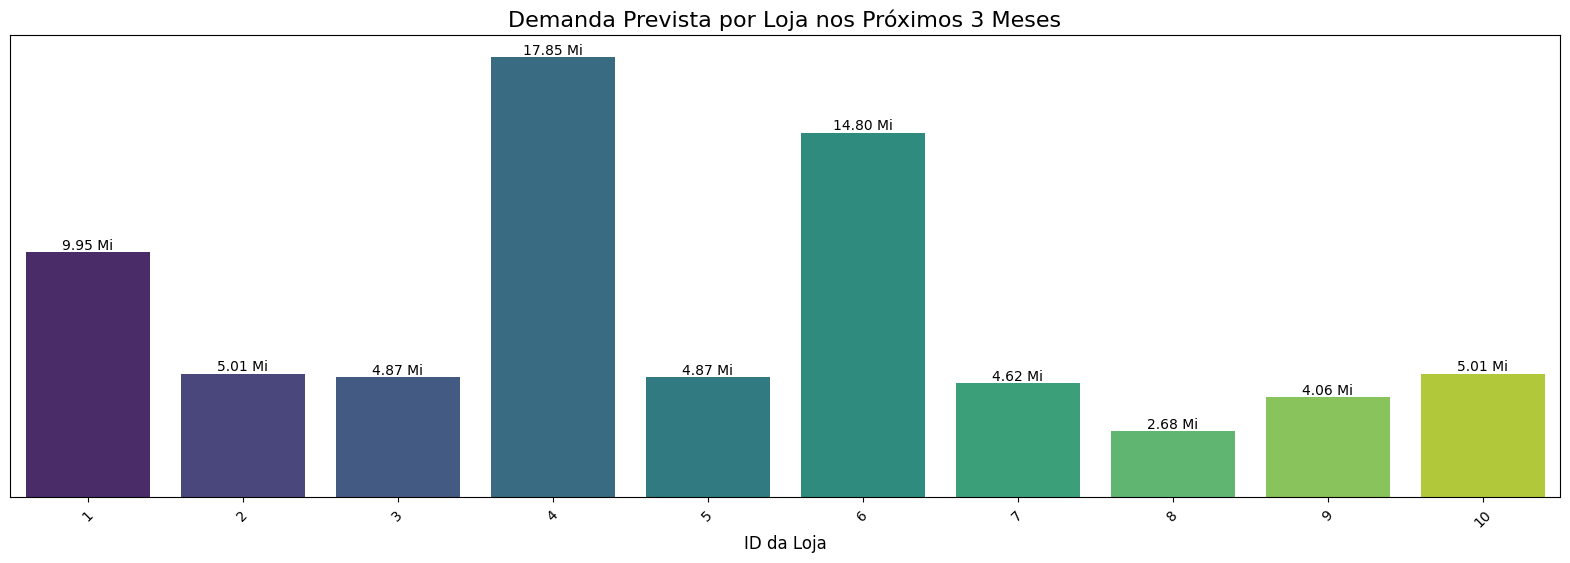

In [10]:
# Gráfico
plt.figure(figsize=(20, 6))
sns.barplot(data=forecast_summary, x='store_id', y='total_forecast_quantity', palette='viridis')

for index, row in forecast_summary.iterrows():
    plt.text(index, row['total_forecast_quantity'], f"{row['total_forecast_quantity'] / 1e6:.2f} Mi", 
             ha='center', va='bottom', fontsize=10)


plt.title("Demanda Prevista por Loja nos Próximos 3 Meses", fontsize=16)
plt.xlabel("ID da Loja", fontsize=12)
plt.ylabel("") 
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

## Sazonalidade

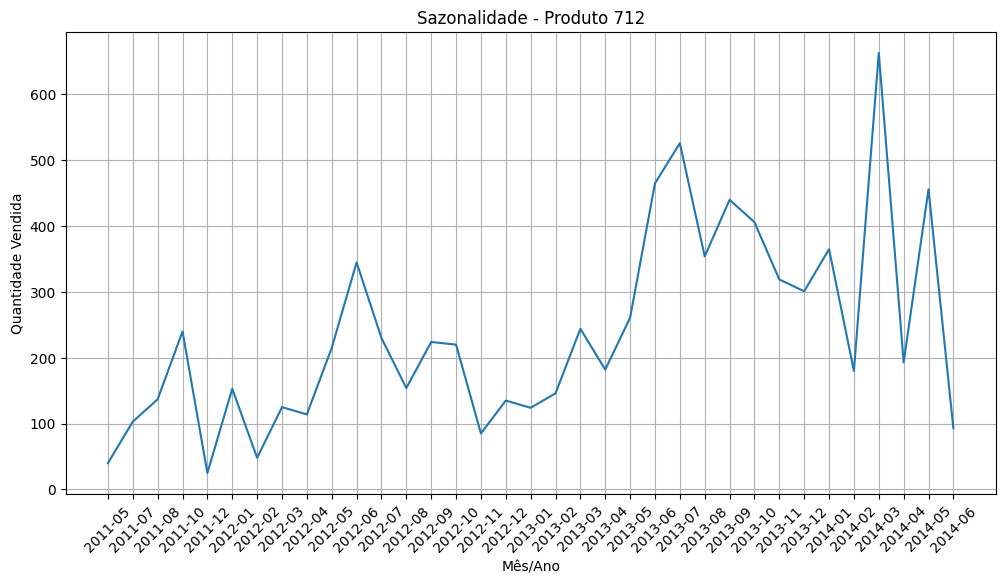

In [11]:
# Produto 712 na tabela de sazonalidade*
produto_712 = fact_product_seasonality[fact_product_seasonality['productid_id'] == 712]

plt.figure(figsize=(12, 6))
sns.lineplot(data=produto_712, x="year_month", y="total_quantity_sold")
plt.title("Sazonalidade - Produto 712")
plt.xlabel("Mês/Ano")
plt.ylabel("Quantidade Vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#doc*: AWC Logo Cap = boné com o logotipo da "Adventure Works Cycles" (AWC)

In [12]:
#doc:sazonalidade por mês/ano
#    - gráfico mostra um comportamento sazonal com picos regulares em meses específicos,como junho (2012-06, 2013-06) e fevereiro (2014-02)
#    - demanda do produto 712 varia ao longo dos anos, mas mantém uma tendência de alta nos meses de junho e fevereiro
#    - há vales regulares em meses como novembro (2013-11) e junho (2014-06), indicando períodos de baixa demanda

C:\Users\wrpen\AppData\Local\Temp\ipykernel_8624\3929377954.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sazonalidade_por_mes, x='month', y='total_quantity_sold', palette='viridis')


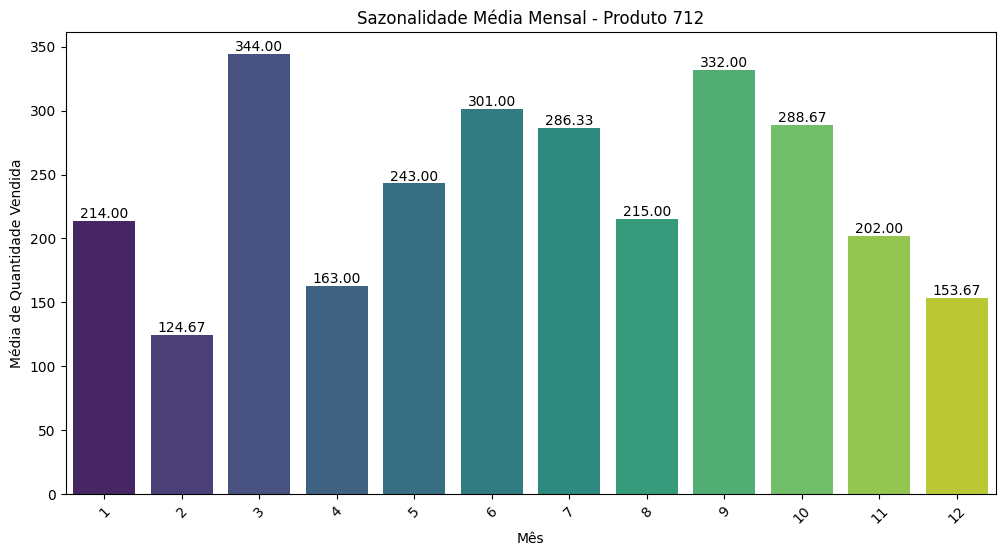

In [13]:
# Agrupar por mês para calcular a média de vendas
produto_712['month'] = pd.to_datetime(produto_712['year_month']).dt.month
sazonalidade_por_mes = produto_712.groupby('month')['total_quantity_sold'].mean().reset_index()

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=sazonalidade_por_mes, x='month', y='total_quantity_sold', palette='viridis')

for index, row in sazonalidade_por_mes.iterrows():
    plt.text(index, row['total_quantity_sold'], f"{row['total_quantity_sold']:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Sazonalidade Média Mensal - Produto 712")
plt.xlabel("Mês")
plt.ylabel("Média de Quantidade Vendida")
plt.xticks(rotation=45)
plt.show()


In [14]:
#doc:sazonalidade média mensal
#    - média de vendas mensal indica que os meses de março (344) e setembro (332) são os de maior demanda para o produto 712
#    - os meses de fevereiro (124,67) e dezembro (153,67) possuem as menores médias, indicando baixa sazonalidade nesses períodos
#    - estratégias:
#       - Alta demanda: focar em campanhas de marketing e aumento de estoque em março, junho e setembro
#       - Baixa demanda: explorar promoções ou incentivos para aumentar as vendas em fevereiro e dezembro

## Questão 9

<!-- 
Para resolver a Questão 9, vamos usar uma abordagem com modelos de regressão para prever a demanda e justificar o modelo com base em métricas de avaliação. Aqui está como estruturaremos a resposta:

Passo 1: Configurar os dados para regressão
Os dados que você já tem (ex: fact_product_seasonality) serão usados para:

Definir as variáveis dependentes (target): total_quantity_sold (demanda).
Definir as variáveis independentes (features): month, year, e outras variáveis que podem influenciar as vendas. -->

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preparando os dados
produto_712['year'] = pd.to_datetime(produto_712['year_month']).dt.year
X = produto_712[['year', 'month']]  # variáveis independentes
y = produto_712['total_quantity_sold']  # variável dependente (target)

# Treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Regressão linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Previsões
y_pred_linear = linear_model.predict(X_test)

# Avaliação do modelo
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Regressão Linear - MAE: {mae_linear:.2f}, MSE: {mse_linear:.2f}, R2: {r2_linear:.2f}")


Regressão Linear - MAE: 51.61, MSE: 5404.83, R2: 0.47


In [17]:
from sklearn.ensemble import RandomForestRegressor

# Modelo Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Previsões
y_pred_rf = rf_model.predict(X_test)

# Avaliação do modelo
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R2: {r2_rf:.2f}")


Random Forest - MAE: 104.24, MSE: 13967.56, R2: -0.37


In [18]:
# Conclusão:
# - a Regressão Linear apresentou melhores resultados com MAE menor (51.61) e R² positivo (0.47),mostrando que é capaz de explicar 47% da variação na 
#   demanda.

# - o modelo Random Forest teve desempenho significativamente pior, com MAE mais alto (104.24) e R² negativo (-0.37), indicando que não é adequado para 
#   este problema.

# - apesar dos resultados limitados da Regressão Linear, ela demonstrou ser a melhor opção para prever a demanda neste cenário, dado o comportamento linear das variáveis.

# - para melhorar os resultados, seria interessante explorar mais variáveis explicativas (ex.: fatores externos como promoções ou sazonalidade) e ajustar hiperparâmetros nos modelos.